In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn3


import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from cooltools.insulation import calculate_insulation_score, find_boundaries
from skimage.filters import threshold_li, threshold_otsu
import pyBigWig
from scipy import linalg
from scipy.signal import argrelextrema


cooltools.__version__

<ipython-input-1-21a864f9ab1d>:22: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


'0.4.0'

In [2]:
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

def cgi_region(clr,region):
    cg = adaptive_coarsegrain(clr.matrix(balance=True).fetch(region),
                              clr.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)
    cgi = interp_nan(cg)
    return(cgi)

def bed3_mids(bed3plus,chrom,start,end):
    a = bed3plus[bed3plus['chrom']==chrom].reset_index()
    mid = (a['start']+a['end'])//2
    b = mid[(mid > start) & (mid < end)]
    return(np.array(b))

def bed3_mids2(bed3plus,chrom,start,end):
    a = bed3plus[bed3plus['chrom']==chrom].reset_index(drop=True)
    mid = (a['start']+a['end'])//2
    b = a[(mid > start) & (mid < end)].iloc[:,[0,1,2]]
    return(b.reset_index(drop=True))

def add_mid(input):
    input['chrom']=input['chrom'].str.replace('chr','')
    input['mid']=(input.end+input.start)//2
    return input

def add_windows(input,region):
    w = snipping.make_bin_aligned_windows(
        resolution,
        input['chrom'],input['mid'],flank_bp=flank)
    w['strand']='.'
#    w['region'] = ce10_X['name'][0]
    w = snipping.assign_regions(w, region)
    return w

nthreads=4
def my_pup_clr(clr,windows,regions):
    clr_snipper = cooltools.snipping.CoolerSnipper(clr, regions=regions)
    with multiprocess.Pool(nthreads) as pool:
        clr_stack = cooltools.snipping.pileup(
            windows,
            clr_snipper.select,
            clr_snipper.snip,
            map=pool.map
            )
    clr_avg = np.nanmean(clr_stack, axis=2)
    return clr_avg

def my_expected(clr,regions):
    with multiprocess.Pool(nthreads) as pool:
        expected = cooltools.expected.diagsum(
            clr,
            regions=regions,
            transforms={
                'balanced': lambda p: p['count'] * p['weight1'] * p['weight2']
            },
            map=pool.map
        )
    expected['balanced.avg'] = expected['balanced.sum'] / expected['n_valid']
    return(expected)

def my_pup_oe(clr,windows,regions,expected):
    expected_snipper = cooltools.snipping.ObsExpSnipper(clr, expected, regions=regions)
    with multiprocess.Pool(nthreads) as pool:
        oe_stack = cooltools.snipping.pileup(
            windows,
            expected_snipper.select,
            expected_snipper.snip,
            map=pool.map
        )
    expected_avg = np.nanmean(oe_stack, axis=2)
    return expected_avg

def bwTobedMatrix(bw,region,nbins):
    lst_region = [region['start'],region['end']]
    lst_bw = []
    for i in range(0,len(lst_region[0])):
        chrom = "".join(['chr', region['chrom'][i]]) # bw uses 'chrI', my bed uses 'I'
        if lst_region[1].reset_index(drop=True)[i] < bw.chroms(chrom):
            if lst_region[0].reset_index(drop=True)[i] > 0:
                v = bw.stats(chrom,
                             lst_region[0].reset_index(drop=True)[i],
                             lst_region[1].reset_index(drop=True)[i],
                             type='mean',nBins=nbins)
            
                lst_bw.append(pd.to_numeric(v,errors='coerce'))
    return(lst_bw)

def InsLocalMax(coolr, windowSize, method):
    x = calculate_insulation_score(coolr, windowSize, verbose=False)
    val = x["log2_insulation_score_"+str(windowSize)].apply(lambda x: x*-1)
    
    x_1 = x[['chrom','start','end','is_bad_bin',"n_valid_pixels_"+str(windowSize)]]
    x_2 = pd.concat([x_1,val],axis=1).reindex(x_1.index)
    y = find_boundaries(x_2,log2_ins_key="log2_insulation_score_"+str(windowSize),
                        n_valid_pixels_key="n_valid_pixels_"+str(windowSize))
    
    if method=='otsu':
        print('otsu')
        t = threshold_otsu(y['boundary_strength'].dropna().values)
    if method =='li':
        print('li')
        t = threshold_li(y['boundary_strength'].dropna().values)
    t_1 = y[y['boundary_strength']>t]    
    print(len(t_1.index))    
    return y,t_1


def InsLocalMax_ofdiff_AminusB(coolrA,coolrB, windowSize, method):
    a = calculate_insulation_score(coolrA, windowSize, verbose=False)
    b = calculate_insulation_score(coolrB, windowSize, verbose=False)
    diff = b[["log2_insulation_score_"+str(windowSize)]]-a[["log2_insulation_score_"+str(windowSize)]]
    a_1 = a[['chrom','start','end','is_bad_bin',"n_valid_pixels_"+str(windowSize)]]
    a_2 = pd.concat([a_1, diff], axis=1).reindex(a_1.index)
    y = find_boundaries(a_2,log2_ins_key="log2_insulation_score_"+str(windowSize),
                        n_valid_pixels_key="n_valid_pixels_"+str(windowSize))
    
    if method=='otsu':
        print('otsu')
        t = threshold_otsu(y['boundary_strength'].dropna().values)
    if method =='li':
        print('li')
        t = threshold_li(y['boundary_strength'].dropna().values)
    t_1 = y[y['boundary_strength']>t]    
    print(len(t_1.index))
    return y,t_1

def QuantilesPandas(dat,Colname):
    boundaryS = dat[Colname]
    q1 = np.quantile(boundaryS,0.25)
    q2 = np.quantile(boundaryS,0.5)
    q3 = np.quantile(boundaryS,0.75)
    #print(q1,q2,q3)
    grp1 = dat[boundaryS<q1]
    grp2 = dat[np.logical_and(boundaryS>=q1, boundaryS<q2)]
    grp3 = dat[np.logical_and(boundaryS>=q2, boundaryS<q3)]
    grp4 = dat[boundaryS>=q3]
    return grp1,grp2,grp3,grp4


def scaling_agg(input_clr,input_regions):
    cvd = cooltools.expected.diagsum(
        clr=input_clr,
        regions=input_regions,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
    )
    lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd)
    lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
        lb_cvd,
        binned_exp_slope=lb_slopes
    )
    lb_cvd_agg['s_bp'] = lb_cvd_agg['diag.avg'] * input_clr.binsize
    lb_slopes_agg['s_bp'] = lb_slopes_agg['diag.avg'] * input_clr.binsize
    x = np.array(lb_slopes_agg['s_bp'])
    y = np.array(lb_slopes_agg['slope'])
    loop_size = x[argrelextrema(y, np.greater)]
    LocalMins = x[argrelextrema(y, np.less)]
    return(lb_cvd_agg,lb_slopes_agg,loop_size,LocalMins)

In [5]:
ce10=bioframe.read_table('/home/kimj50/ce10.chrom.sizes',schema='bed3')
ce10=bioframe.parse_regions(ce10)


INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
# clrs
res = '500'
clr_notag = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_JK08_30_"+res+"_raw.cool")
clr_smc3 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK153_JK180_30_"+res+"_raw.cool")
clr_wapl = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK155_combined_JK181_30_"+res+"_raw.cool")

clrs = [clr_notag,clr_smc3,clr_wapl]

In [6]:
#################################### beginning of Ps, combined data slopes, X/A ##########################################

#### Ps, combined dat split XA ####
clrs

agg_XA_clrs_conditions = []
for i in range(len(clrs)):
    agg_XA = []
    a = scaling_agg(clrs[i],ce10.iloc[0:4].reset_index(drop=True))
    x = scaling_agg(clrs[i],ce10.iloc[[5]].reset_index(drop=True))
    agg_XA.append(a)
    agg_XA.append(x)
    agg_XA_clrs_conditions.append(agg_XA)
    


max: [399423.83409354]
min: [  31416.16826436 3991429.59839308]
max: [399424.4840999]
min: [  15763.62706305 3991488.487693  ]
max: [ 24959.66973535 502947.88600839]
min: [   6204.63266467  100200.92953821 3991487.20373742]
max: [158813.41926469]
min: [  19872.75018512 3172475.08881767]
max: [158813.16339356]
min: [   7826.12389649 3172455.2824579 ]
max: [ 19872.66967327 158813.32172728]
min: [   4834.70830399   79461.63949019 3172453.81028996]


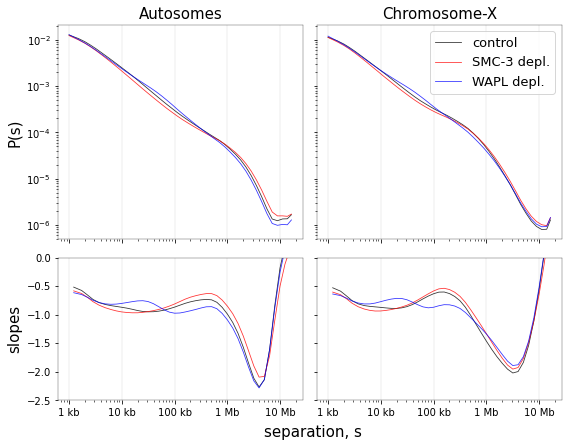

In [7]:
########################## PsX,psA, chromosome grouped ############################
f, axs = plt.subplots(
    figsize=(8,6),
    ncols=2,
    nrows=2,
    sharex=True, sharey='row',
    gridspec_kw={'height_ratios':[6,4]}
)

# sample grouping #
dat_agg = agg_XA_clrs_conditions
# structure: layer1=conditions, layer2=A,X, layer3=ps,slopes,loopsize #

# global params and labels #
Alpha = 0.8
lineWidth = 0.8
bigFont = 16
smallFont = 9
slopes_minmax = [-2.5,0]
subtitles = ['Autosomes','Chromosome-X']
labels = ['control',
          'SMC-3 depl.',
          'WAPL depl.']

colors = ['black', 'red','blue']

# global params and labels #
Alpha = 0.8
lineWidth = 0.8
bigFont = 15
smallFont = 10

lineStyle=['-',':','--']
# plot #
for s in range(2):
    ax1 = axs[0,s]
    ax2 = axs[1,s]
    for axis in ['top', 'bottom', 'left', 'right']:
        ax1.spines[axis].set_linewidth(0.3)
        ax2.spines[axis].set_linewidth(0.3)
    for j in range(len(dat_agg)):
        ax1.loglog(
            dat_agg[j][s][0]['s_bp'],
            dat_agg[j][s][0]['balanced.avg'],
            label=labels[j],
            color=colors[j],linewidth=lineWidth,alpha=Alpha
        )
        ax2.semilogx(
            dat_agg[j][s][1]['s_bp'],
            dat_agg[j][s][1]['slope'],
            label=labels[j],
            color=colors[j],linewidth=lineWidth,alpha=Alpha
        )
        ls = min(dat_agg[j][s][2])
        print('max:',dat_agg[j][s][2])
        print('min:',dat_agg[j][s][3])
#        ax2.axvline(ls,ymin=0.1,ymax=0.22, 
#                    alpha=Alpha,linewidth=lineWidth,color=colors[j],linestyle=lineStyle[j])
    ax1.grid(lw=0.2,axis='x')
    ax2.grid(lw=0.2,axis='x')
    format_ticks(ax2,y=False,rotate=False)
    ax2.tick_params(labelsize=smallFont)
    ax2.set_ylim(slopes_minmax)
    ax1.set_title(subtitles[s],size=bigFont)

# ylabel
axs[0,0].set_ylabel('P(s)',size=bigFont)
axs[1,0].set_ylabel('slopes',size=bigFont)

# big xlabel
f.text(0.55, -0.02, 'separation, s', ha='center',fontsize=bigFont)

#add legend to plot
handles, labels = axs[0,1].get_legend_handles_labels()
axs[0,1].legend(prop={'size': 13})


plt.tight_layout()

In [8]:
#################### meta jets ####################
res = "1000"

clr_notag = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_JK08_30_"+res+"_raw.cool")
clr_smc3 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK153_JK180_30_"+res+"_raw.cool")
clr_wapl = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK155_combined_JK181_30_"+res+"_raw.cool")

clrs = [clr_notag,clr_smc3,clr_wapl]


In [9]:
######################## jet quantile ##############
#### chromosome wide ####
ce10=bioframe.read_table('/home/kimj50/ce10.chrom.sizes',schema='bed3')
ce10=bioframe.parse_regions(ce10)


########## pile-ups at jets #################
flank=100000
resolution=1000


q1 = bioframe.read_table('/home/kimj50/cohesin_paper/jets_call/jetcall_v5_w30kb_q1.bed',schema='bed4')
q2 = bioframe.read_table('/home/kimj50/cohesin_paper/jets_call/jetcall_v5_w30kb_q2.bed',schema='bed4')
q3 = bioframe.read_table('/home/kimj50/cohesin_paper/jets_call/jetcall_v5_w30kb_q3.bed',schema='bed4')
q4 = bioframe.read_table('/home/kimj50/cohesin_paper/jets_call/jetcall_v5_w30kb_q4.bed',schema='bed4')
jets_annot_q = [q1,q2,q3,q4]

windows_jets_q = []
for i in range(4):
    jets_annot_qi = jets_annot_q[i]
    add_mid(jets_annot_qi)
    windows_jets_q.append(add_windows(jets_annot_qi,ce10))
    

In [10]:
########### expected for oe ###############

clrs
clrs_exp = []
for s in range(len(clrs)):
    print(s)
    x = my_expected(clrs[s],ce10)
    clrs_exp.append(x)
    
    

0
1
2


In [11]:
####### per quantile ############
#### pile up jets ####
pup_oe_q = []
for s in range(len(clrs)):
    pup_s = []
    for q in range(4):
        x = my_pup_oe(clrs[s],windows_jets_q[q],ce10,clrs_exp[s])
        pup_s.append(x)
    pup_oe_q.append(pup_s)


<ipython-input-2-8052c0632f96>:78: RuntimeWarning: Mean of empty slice
  expected_avg = np.nanmean(oe_stack, axis=2)


<ipython-input-12-7301b92c8770>:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


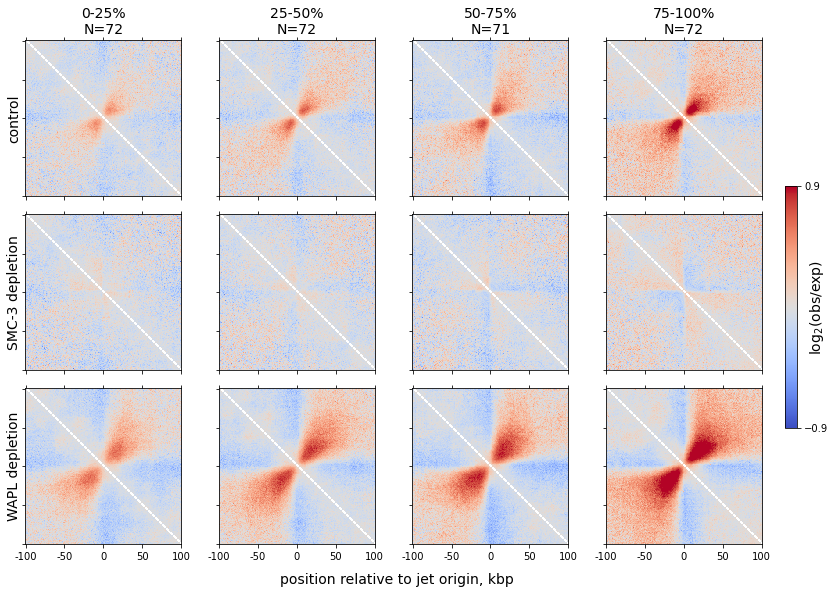

In [12]:
################## pileup ##############
f, axs = plt.subplots(
    figsize=(11,8),
    ncols=4,nrows=3,
    sharey=True,
    sharex=True)

start, end = [0,flank*2//resolution]
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)

#pup_obs_oe
# structure: layer1=conditions,layer2=obs,obs/exp

# global params and labels #
Alpha = 0.8
lineWidth = 0.8
bigFont = 14
smallFont = 10
minmax_oe = [-0.9,0.9]

yLabs = ['control','SMC-3 depletion','WAPL depletion']

sub_titles = ['0-25%\nN='+str(len(windows_jets_q[0])),'25-50%\nN='+str(len(windows_jets_q[1])),
              '50-75%\nN='+str(len(windows_jets_q[2])),'75-100%\nN='+str(len(windows_jets_q[3]))]
dat = pup_oe_q
for s in range(len(dat)):
    for q in range(4):
        ax = axs[s,q]
    
    
        im = ax.matshow(
            np.log2(dat[s][q]),
            cmap='coolwarm',
            vmin=minmax_oe[0],vmax=minmax_oe[1])

        ax.set(xticks=ticks_pixels,xticklabels=ticks_kbp)

        axs[0,q].set_title(sub_titles[q],fontsize=bigFont)

        axs[0,q].tick_params(labelsize=smallFont,labelbottom=False, labeltop=False, labelleft=False)
        axs[1,q].tick_params(labelsize=smallFont,labelbottom=False, labeltop=False, labelleft=False)
        axs[2,q].tick_params(labelsize=smallFont,labelbottom=True, labeltop=False, labelleft=False)
    axs[s,0].set_ylabel(yLabs[s],fontsize=bigFont)
#axs[1,0].set_ylabel('X-chromosome'+'\nN='+str(len(windows_jets_X)),fontsize=bigFont)


### line
#x1, y1 = [100, 200], [100, 0]
#x2, y2 = [0, 100], [0, 50]
#axs[0,0].plot(x1, y1, marker = 'o')


## cbar ##
cbaxes = f.add_axes([1, .250, 0.015, 0.42])
cbar = plt.colorbar(im, cax = cbaxes,ticks=[minmax_oe[0],minmax_oe[1]])
cbar.ax.get_yaxis().labelpad = 2
cbar.ax.set_ylabel('$\log_{2}$(obs/exp)', rotation=90,fontsize=bigFont,labelpad=-20)

f.text(0.51, -0.02, 'position relative to jet origin, kbp', ha='center',fontsize=bigFont)



plt.tight_layout()